<a href="https://colab.research.google.com/github/brentkendrick/HPLC-Data-Analysis/blob/master/Peak_fitting_and_integration_top_8_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
%pip install peakutils

# <b>Summary of Findings</b>

## <font color='green'>Models to Keep for Further Evaluation</font>

### Standard Gaussian model (control model) 

The Gaussian peak takes the general form:  $y = he^{-\frac{1}{2}\left(\frac{(x-\mu)}{2\sigma}\right)^2}$

3 parameters: h, $\mu$, and $\sigma$

### Modified Haarhoff-van der Linde (HVL) model
Haarhoff, P. H., Van der Linde, H. J., Anal. Chem. 1966, 38, 573–582. and García-Alvarez-Coque et. al. Electrophoresis 2005, 26, 2076–2085  


$$y = h\frac{exp\left[-\frac{1}{2} \left(\frac{t-\mu}{\sigma}\right)^2\right]}
                                         {\left[exp\left(\frac{a\mu}{10^4a\sigma^2}\right)\right]^{-1} + 
                                         \frac{1}{2}\left[erf\left(\frac{t-\mu}{\sigma\sqrt2}\right)\right]}$$


4 parameters: h, $\mu$, $\sigma$, a (asym factor)  

Kendrick modifications: Since function was originally designed for triangular-Gaussian electrophoretic peak shapes...removed/replaced parameters that did not appreciably impact the overall fit, and modified asymmetry factor multiplication factor. 

### LMG Gaussian model

Linear modified gaussian, from J.Chrom.A. 2017, 1515, 129-137  

$$ y = he^{-\frac{1}{2}\frac{(t - \mu)^2}{(\sigma+b(t - \mu))^2}}$$

4 parameters: h, $\mu$, $\sigma$, b (asym factor) 

### Empirically transformed Gaussian (ETG) peak model

$$ y = \frac{h2}{\left[1 + {\lambda_L}e^{k_L(t_L - t)}\right]^{(t_L/t)^\alpha} +
                         \left[1 + {\lambda_T}e^{k_T(t - t_T)}\right]^{(t/t_T)^\beta} - 1}$$
where:
 - t is time
 - h2 is related to peak amplitude
 - ${\lambda_L}$ and ${\lambda_T}$ are pre-exponential parameters
 - ${k_L}$ and ${k_T}$ are parameters related to speed of rise and fall of leading and trailing edges, respectively
 - $\alpha$ and $\beta$ are parameters to further modify shapes of leading and trailing edges, respectively
 - $t_L$ and $t_T$ are x-positions of leading and trailing edges at fwhm
 
 J. Li, “Comparison of the capability of peak functions in describing real chromatographic peaks,” Journal of Chromatography A, vol. 952, no. 1–2, pp. 63–70, Apr. 2002

## <font color='red'>Models to Remove from Consideration</font>
### Parabolic Lorentzian-modified Gaussian (PLMG) model

$$y = h*exp\left[-\frac{1}{2} \frac{(t-t_r)^2}{w_0^2 + c^2\frac{(t-t_r + d)^2}{1 + m^2 (t-t_r-r)^2}}\right]$$

7 parameters: h, $\mu$, w0, d, c, r, m  
 w0, d, c: parabolic parameters
 r, m:  Lorentzian parameters

Acceptable fit, but can easily converge to different minima, parameters need much different starting points for each peak, and parameters aren't intuitive  
from García-Alvarez-Coque et. al. Electrophoresis 2005, 26, 2076–2085

### EMG peak model 

$$y = \frac{Ae^qI}{2\tau}$$
where:
$$q = \frac{\sigma^2}{2\tau^2} -\frac{t-t_R}\tau$$

$$I = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^z e^{-x^2/2} \, dx$$

and:
$$z = \frac{t-t_R}\sigma - \frac{\sigma}{\tau}$$

4 parameters: A, $\mu$, $\sigma$, $\tau$

Better fit than Gaussian, only 1 additional parameter than Gaussian, however, LMG also has 4 parameters, with an overall better fit to asymmetric peaks

### Generalized exponentially modified Gaussian (GEMG) peak model

$$y = \frac{A}{2(1+b)}\left[\frac{e^{q_1}I_1}{\tau_1} + \frac{e^{q_2}I_2}{\tau_2}\right]$$
where:
$$q_i = \frac{\sigma^2}{2\tau_i^2} -\frac{t-t_R}{\tau_i}$$

$$I_i = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{z_i} e^{-x^2/2} \, dx$$

and:
$$z_i = \frac{t-t_R}\sigma - \frac{\sigma}{\tau_i}$$  


5 parameters: A, $\mu$, $\sigma$, $\tau1$, $\tau2$  

Better fit than Gaussian, 2 more parameters than Gaussian, not dramatically better than EMG

### Generalized logistic model

$$y = \frac{hC}{B} \frac{Exp\left(\frac{Dt}{B}\right)}{\left[1+ Exp\left(\frac{Dt}{B} \right)\right]^{C+1}}$$

where:

5 parameters: h, $\mu$, B, C, D  
B, C and D are logistic fitting parameters.  h added to equation to scale appropriately to peak height.  

Better fit than Gaussian, 2 more parameters than Gaussian, not dramatically better than EMG


In [0]:
# %pip install peakutils

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import peakutils
from peakutils.plot import plot as pplot
import math

from scipy.special import erf
from scipy.special import erfc
from scipy.optimize import least_squares

from math import sqrt, pi, log
from numpy import exp, ravel

import requests

import itertools
flatten = itertools.chain.from_iterable #tool to flatten a nested list

In [0]:
# Define empty functions to prevent peak method from failing before functions are called

def gaussian():
    pass

def EMG():
    pass

def GEMG():
    pass

def GLM():
    pass

def HVL():
    pass

def PLMG():
    pass

def ETG():
    pass

def LMG():
    pass

In [0]:
def component_pks(x, meth, *flat_params):  
    # function to create list of individual peak y-values, with flat list passed in for all parameters
    
    # function mapper, takes in string and maps it to known functions
    fun =  {
            'gaussian':gaussian,
            'EMG':EMG,
            'GEMG':GEMG,  
            'GLM':GLM,
            'HVL':HVL,
            'PLMG':PLMG,
            'ETG':ETG,
            'LMG':LMG,       
           } 
    
    num_pks = int(len(pk_idx))
    num_fun_params = int(len(flat_params)/num_pks)
    
    # create empty array for y - data for all peaks
    out = np.zeros(int(len(x)*num_pks))
    out = np.split(out, num_pks)
    
    # create empty array for parameters for all peaks
    params = np.zeros(int(len(flat_params)*num_pks))
    params = np.split(params, num_pks)    
    
    j = 0           
    for i in range(num_pks):
        params = flat_params[j: (j + num_fun_params)]
        out[i] = fun[meth](x, *params)
        j += num_fun_params
    
    return out

In [0]:
pk_sum = lambda x, method, *params: sum(component_pks(x, method, *params)) # function to combine indiv peaks

In [0]:
residual = lambda p0, y, x, method: pk_sum(x, method, *p0) - y # residual (error) function for least_sq minimization

Figure plotting methods

In [0]:
def single_plot(x, y):
    plt.figure()
    plt.plot(x, y)
    plt.xlabel('Time (s)')
    plt.ylabel('y (arb. units)')
    return

In [0]:
def two_plot(x, y, y_fit):
    plt.figure(figsize = (12, 5))
    plt.plot(x, y, label = 'y-data')
    plt.plot(x,y_fit,'g-', label = 'fitted y-data')
    plt.xlabel('Time (s)')
    plt.ylabel('y (arb. units)')
    plt.legend()
    # plt.savefig('deconvolution-3.png')
    return

In [0]:
def fit_summary(x, y, ind_pk_ys, ind_pk_area_pcts):

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(x, y)
    txt_box = []
    for i in range(int(len(ind_pk_area_pcts))):

        text_tmp = ('Area {}  is {:1.2%} of the whole area'.format(str(i+1), ind_pk_area_pcts[i]))
        txt_box.append(text_tmp)

        ax.plot(x, ind_pk_ys[i])

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('y (arb. units)')

    ax.legend(['y-data', 'peak 1', 'peak 2'])    
    textstr = '\n'.join(map(str, txt_box))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
                
    plt.show()
    return


# Peak statistics

In [0]:
def peak_areas(x, peaklist):
    pk_area = []    
    for i in range(int(len(peaklist))):
        
        pk_area_tmp = np.trapz(peaklist[i], x) #integrates individual fitted peak
        pk_area.append(pk_area_tmp)#packs each peak area into a list
        
    pk_area_pct = []    
    for i in range(int(len(peaklist))):
        pk_area_pct_temp = pk_area[i]/(sum(pk_area))
        pk_area_pct.append(pk_area_pct_temp) 
                                       
        print ('Area {}  is {:1.2%} of the whole area'.format(str(i+1), pk_area[i]/(sum(pk_area))))

    return pk_area_pct

In [0]:
def wsd(y, y_fit):
    """Calculates the WSD for two samples"""
    n = int(len(y))
    y_avg = sum(y) / n
    wsd_sq = 0
    for i in range(n):
        wsd_sq = wsd_sq + (1 / n) * \
            (abs(y[i]) / abs(y_avg)) * ((y_fit[i]) - (y[i]))**2
    wsd = math.sqrt(wsd_sq)
    return wsd

In [0]:
def overlap(x, y, y_fit):
    """Calculates area of commonality / overlap"""

    y_fit_area = np.trapz(y_fit, x)  #integrate area of y_fit
    y_fit_norm = y_fit/y_fit_area  #area normalize to 1
    
    y_area = np.trapz(y, x)
    y_area_norm = y/y_area
    
    y_min = np.minimum(y_area_norm,y_fit_norm)  # finds stepwise minimum element of both datasets

    y_min_area = np.trapz(y_min, x) # get area of y_min
   
    return y_min_area

In [0]:
def R2(resid, y):
    return (1 - np.sum((resid ** 2))/np.sum((y - y.mean())**2))  #gives R-squared of fit

In [0]:
def dca(x, y, y_fit):
    """Calculates the derivative correlation algorithm (DCA) for two samples in the DataFrame"""
    n = int(len(y))
    p_sq = 0
    A = 0
    B = 0
    C = 0
    # create a list of n elements, all zero to make endpoints zero after loop below
    y_der = [0] * n
    y_fit_der = [0] * n

    for i in range(2, n - 1):  # want i = 1 and i = n elements equal to zero
        y_der[i] = (y[i + 1] - y[i - 1]) / 2
        y_fit_der[i] = (y_fit[i + 1] - y_fit[i - 1]) / 2

    for i in range(n):
        A = A + y_der[i] * y_fit_der[i]
        B = B + (y_der[i])**2
        C = C + (y_fit_der[i])**2

    p_sq = (A**2 / (B * C))
    p = math.sqrt(p_sq)
    DCA_value = (p**21 + p) / 2
    return DCA_value

# Individual peak data and characteristics

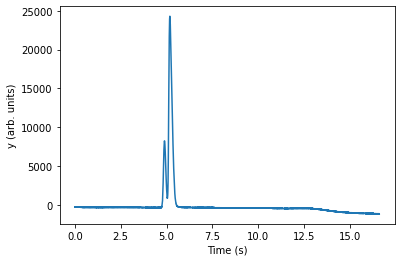

In [37]:
#Dataset from http://kitchingroup.cheme.cmu.edu/blog/2013/01/29/Curve-fitting-to-get-overlapping-peak-areas/

# Code to retrieve file from url
url = 'https://raw.githubusercontent.com/brentkendrick/Public-HPLC-files/master/gc-data-21.txt'
r = requests.get(url).text
lines = r.split("\n")

# Code to retrieve from local directory
# datafile = 'gc-data-21.txt'
# with open(datafile) as f:
#     lines = f.readlines()

i = 0
for i,line in enumerate(lines):
    if '# of Points' in line:
        npoints = int(line.split()[-1])
    elif 'R.Time	Intensity' in line:
        i += 1
        break

# now get the data
x_orig, y_orig = [], []
for j in range(i, i + npoints):
    fields = lines[j].split()
    x_orig += [float(fields[0])]
    y_orig += [int(fields[1])]

x_orig = np.array(x_orig)
y_orig = np.array(y_orig)

# now plot the data in the relevant time frame
single_plot(x_orig, y_orig)

In [38]:
# Conversion factor for peak array x-indices to retention time (s) units
x_to_index_ratio = (x_orig[-1] - x_orig[0])/len(x_orig)
x_to_index_ratio

0.0016664991473568063

In [39]:
# Get index positions of desired starting and ending retention time
left_cut = int(round(4/x_to_index_ratio)) 
right_cut = int(round(6/x_to_index_ratio))
right_cut

3600

In [0]:
# Truncate data to region of interest and offset to min value (no negative y values) to simplify peak fitting
x = x_orig[left_cut:right_cut]
y = y_orig[left_cut:right_cut]

In [0]:
# Zero the baseline to facilitate curve-fitting
y = y-y.min()

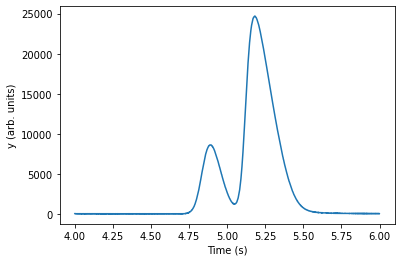

In [42]:
single_plot(x, y)

# Find relevant peaks and peak parameters

In [0]:
def find_peaks(x, y, idx_conv, height=None, threshold=None, distance=1, prominence = None, width=None):
    ''' 
    Find peak positions (returns array of peak indices, which can be converted to x-values by x[peaks])
    
    height:     Required height of peaks.
    threshold:  Vertical distance of peak to its neighbouring samples
    distance:   Required minimal horizontal distance (>= 1) in samples between neighbouring peaks. 
                Smaller peaks are removed first until the condition is fulfilled for all remaining peaks.
    prominance: The prominence of a peak measures how much a peak stands out from the surrounding baseline 
                of the signal and is defined as the vertical distance between the peak and its lowest contour line
    width:      Required width of peaks in samples
    '''
    
    from scipy.signal import chirp, find_peaks, peak_widths
    
    pk_idx, _ = find_peaks(y, height = height, threshold = threshold, 
                          distance = distance, prominence = prominence, width = width)
    
    # get y-value of each peak at the peak index
    h = y[pk_idx] 
    tR = x[pk_idx]
    
    '''return pk widths, height of base, left and right and positions as 
    interpolated indices at relative peak height'''
    full_width_idx, full_width_ht, full_L_pos_idx, full_R_pos_idx = peak_widths(y, pk_idx, rel_height = 1.0)  
    half_width_idx, half_width_ht, half_L_pos_idx, half_R_pos_idx = peak_widths(y, pk_idx, rel_height = 0.5)
    
    # Convert peak attributes from index values to original x-value units
    full_L_pos = full_L_pos_idx*idx_conv + x[0]
    full_R_pos = full_R_pos_idx*idx_conv + x[0]
    pk_full_width = full_width_idx*idx_conv

    
    half_L_pos = half_L_pos_idx*idx_conv + x[0]
    half_R_pos = half_R_pos_idx*idx_conv + x[0]
    fwhm = half_width_idx*idx_conv
    
    plt.plot(x,y)
    plt.plot(x[pk_idx], h,'x')
    plt.hlines(full_width_ht, full_L_pos, full_R_pos, color="C3")
    plt.hlines(half_width_ht, half_L_pos,half_R_pos , color="C2")
    
    plt.show()
    
    return pk_idx, h, fwhm, tR, half_L_pos, half_R_pos

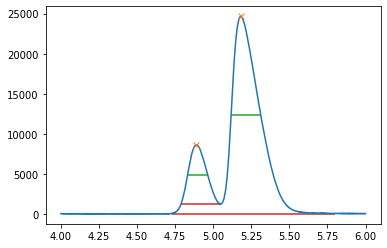

In [44]:
pk_idx, h, fwhm, mu, pk_half_L, pk_half_R = find_peaks(x, y, x_to_index_ratio, height = 5000, threshold = None, distance = 10, prominence = None, width = None)

In [0]:
xc = [x - mu_element for mu_element in mu] # creates arrays of x-centered peak data

# Abbreviations

Id  | Description 
--|:---------
x|source x-axis data            
mu or tR|$\mu$ mean (center) of peak (tR is peak retention time) 
s| $\sigma$, standard deviation, i.e. $\sqrt{variance}$, where variance isthe average of the squared differences of the x-values from the mean. 
y | source intensity (absorbance) axis data   
h | peak height(s)  
fwhm| peak full width at half maximum of peak height  
p0 | initial parameters for peak fitting  

# Peak models

# Standard Gaussian model

Standard peak relationships include:

$\sigma = \frac{fwhm}{2\sqrt{2ln2}} \approx$ 0.4247*fwhm

The Gaussian peak takes the general form:  $y = he^{-\frac{1}{2}\left(\frac{(x-\mu)}{2\sigma}\right)^2}$


<img src="https://upload.wikimedia.org/wikipedia/commons/7/74/Normal_Distribution_PDF.svg" width="400" height="200" />

In [0]:
def gaussian(x, h, mu, s):  
    return h*exp(-(x - mu)**2/(2*s**2)) #Function defining a gaussian distribution

In [0]:
s = fwhm/(2*sqrt(2*log(2))) # convert fwhm from peak detection method to sigma

In [0]:
gaussian_p0 = list(flatten(zip(h, mu, s))) # create 1-D list of all peak fitting parameters

In [0]:
y_gaussian_p0 = pk_sum(x, 'gaussian', *gaussian_p0)  # y data of initial parameter estimates

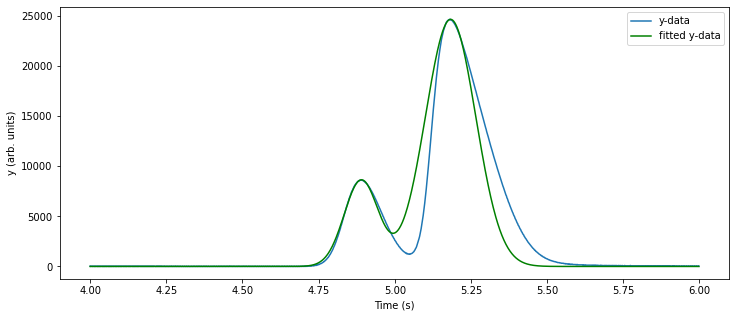

In [50]:
two_plot(x, y, y_gaussian_p0) # show overlay of initial guess and data to fit

In [0]:
opt_gaussian = least_squares(residual, gaussian_p0, loss='linear', bounds=(-np.inf, np.inf), args=(y, x, 'gaussian'))
gaussian_p, gaussian_resid = opt_gaussian.x, opt_gaussian.fun

In [0]:
opt_gauss_pks = component_pks(x, 'gaussian', *gaussian_p) # list of individual optimized gaussian peaks

In [53]:
opt_gauss_pk_areas = peak_areas(x, opt_gauss_pks)

Area 1  is 19.36% of the whole area
Area 2  is 80.64% of the whole area


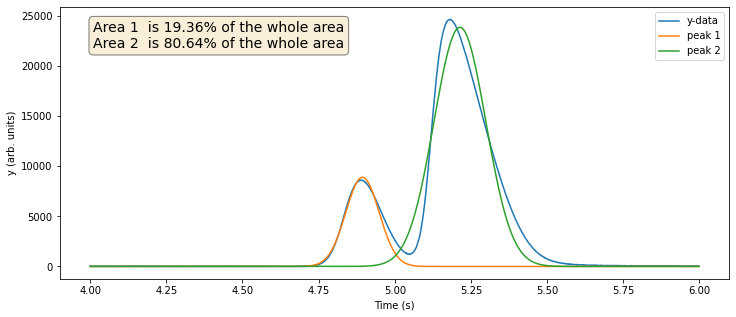

In [54]:
fit_summary(x, y, opt_gauss_pks, opt_gauss_pk_areas)

In [55]:
R2_gaussian = R2(gaussian_resid, y)
R2_gaussian

0.9675591936846375

In [56]:
wsd_gaussian = wsd(y, sum(opt_gauss_pks))
wsd_gaussian

2060.7152817405813

In [57]:
AOO_gaussian = overlap(x, y, sum(opt_gauss_pks))
AOO_gaussian

0.9141147258017361

In [58]:
dca_gaussian = dca(x, y, sum(opt_gauss_pks))
dca_gaussian

0.4541605807863209

# EMG peak model

$$y = \frac{Ae^qI}{2\tau}$$
where:
$$q = \frac{\sigma^2}{2\tau^2} -\frac{t-t_R}\tau$$

$$I = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^z e^{-x^2/2} \, dx$$

and:
$$z = \frac{t-t_R}\sigma - \frac{\sigma}{\tau}$$


Error function, erf(x): $$\frac{2}{\sqrt\pi}\int_0^x e^{-t^2} \, dt $$

Complementary error function, erfc(x): 1-erf(x)$$ = \frac{2}{\sqrt\pi}\int_x^\infty e^{-t^2} \, dt $$


I, in terms of the erfc(x):

$$I = erfc\left[\frac{-1}{\sqrt2}\left(\frac{t-t_R}{\sigma}-\frac{\sigma}{\tau}\right)\right] $$



A Gaussian peak with height h, and FWHM has an area of:
$$A = 1.0645*h*FWHM$$
or
$$2.5067*h*\sigma$$
https://terpconnect.umd.edu/~toh/spectrum/Integration.html

EMG peak fitting:
Plot the fitting function with an initial guess using inputs from the peak finder algorithm for each parameter. Tau, $\tau$, is an asymmetry parameter

Exponentially modified gaussian function, from Journal of Chemometrics. 2011;25(7):352-356, using a slightly simplified form from: from Anal. Chem. 1994, 66, 1294-1301  


In [0]:
def EMG(x, A, mu, s, tau):
    return (A/(2*tau))*(exp(1/2*(s/tau)**2 - (x - mu)/tau))*(erfc(1/sqrt(2)*(-((x-mu)/s-s/tau))))

In [0]:
A = [1.0645*x1*x2 for x1, x2 in zip(h, fwhm)]  # estimate peak areas, A

In [0]:
EMG_p0 = list(flatten(zip(A, mu, s, [0.03, 0.05]))) # create 1-D list of all peak fitting parameters

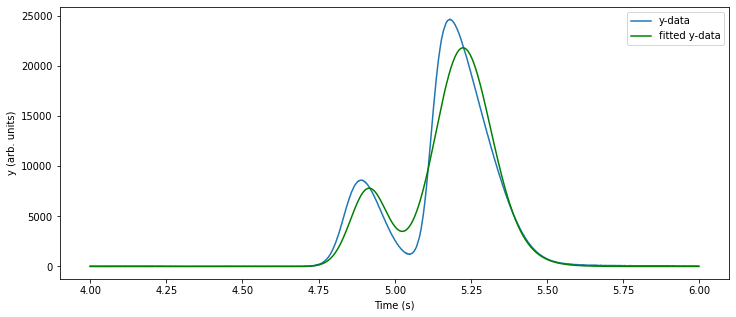

In [62]:
EMG_guess_y = pk_sum(x, 'EMG', *EMG_p0)
two_plot(x, y, EMG_guess_y)

In [0]:
opt_EMG = least_squares(residual, EMG_p0, loss='linear', bounds=(-np.inf, np.inf), args=(y, x, 'EMG'))
EMG_p, EMG_resid = opt_EMG.x, opt_EMG.fun

In [0]:
opt_EMG_pks = component_pks(x, 'EMG', *EMG_p) # list of individual optimized gaussian peaks

In [65]:
opt_EMG_pk_areas = peak_areas(x, opt_EMG_pks)

Area 1  is 19.78% of the whole area
Area 2  is 80.22% of the whole area


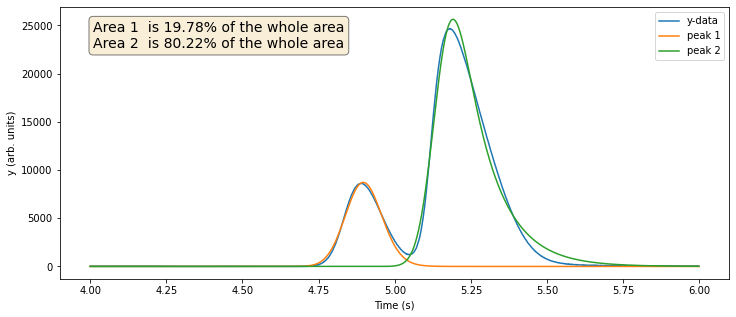

In [66]:
fit_summary(x, y, opt_EMG_pks, opt_EMG_pk_areas)

In [67]:
R2_EMG = R2(EMG_resid, x)
R2_EMG

-806032.069023298

In [68]:
# LMG_fitted_y = LMG_pk_sum(t, *LMGguess)
wsd_EMG = wsd(y, sum(opt_EMG_pks))
wsd_EMG

916.409911472126

In [69]:
AOO_EMG = overlap(x, y, sum(opt_EMG_pks))
AOO_EMG

0.9518213213886455

In [70]:
dca_EMG = dca(x, y, sum(opt_EMG_pks))
dca_EMG

0.7050928406922807

# Generalized exponentially modified Gaussian (GEMG) peak model

$$y = \frac{A}{2(1+b)}\left[\frac{e^{q_1}I_1}{\tau_1} + \frac{e^{q_2}I_2}{\tau_2}\right]$$
where:
$$q_i = \frac{\sigma^2}{2\tau_i^2} -\frac{t-t_R}{\tau_i}$$

$$I_i = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{z_i} e^{-x^2/2} \, dx$$

and:
$$z_i = \frac{t-t_R}\sigma - \frac{\sigma}{\tau_i}$$


Error function, erf(x): $$\frac{2}{\sqrt\pi}\int_0^x e^{-t^2} \, dt $$

Complementary error function, erfc(x): 1-erf(x)$$ = \frac{2}{\sqrt\pi}\int_x^\infty e^{-t^2} \, dt $$


I, in terms of the erfc(x):

$$I = erfc\left[\frac{-1}{\sqrt2}\left(\frac{t-t_R}{\sigma}-\frac{\sigma}{\tau_i}\right)\right] $$



Tau, $\tau1$ and $\tau2$, are asymmetry parameters, and b is the fractional contribution of the second exponential function.  

Generally Exponentially modified gaussian function, from Nikitas et. al . 2001.


In [0]:
def GEMG(x, A, mu, s, tau1, tau2, b):     
    return A/(2*(1+b))*(
        ((exp(1/2*(s/tau1)**2 - (x - mu)/tau1))*(erfc(-1/sqrt(2)*((x-mu)/s - s/tau1))))/tau1 + 
        ((exp(1/2*(s/tau2)**2 - (x - mu)/tau2))*(erfc(-1/sqrt(2)*((x-mu)/s - s/tau2))))/tau2) 

In [0]:
GEMG_p0 = list(flatten(zip(A, mu, s, [0.1, 0.1], [0.02, 0.02], [0.9, 0.9]))) # create 1-D list of all peak fitting parameters

In [0]:
y_GEMG_p0 = pk_sum(x, 'GEMG', *GEMG_p0)  # y data of initial parameter estimates

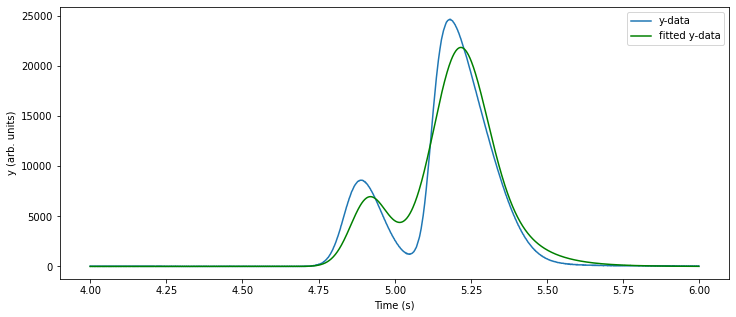

In [74]:
two_plot(x, y, y_GEMG_p0)

In [0]:
opt_GEMG = least_squares(residual, GEMG_p0, loss='linear', bounds=(-np.inf, np.inf), args=(y, x, 'GEMG'))
GEMG_p, GEMG_resid = opt_GEMG.x, opt_GEMG.fun

In [0]:
opt_GEMG_pks = component_pks(x, 'GEMG', *GEMG_p) # list of individual optimized gaussian peaks

In [77]:
opt_GEMG_pk_areas = peak_areas(x, opt_GEMG_pks)

Area 1  is 19.77% of the whole area
Area 2  is 80.23% of the whole area


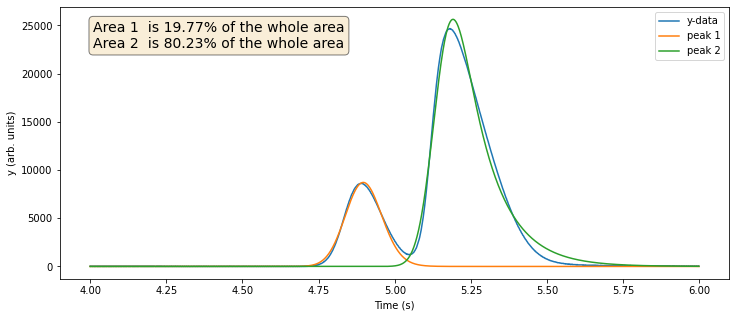

In [78]:
fit_summary(x, y, opt_GEMG_pks, opt_GEMG_pk_areas)

In [79]:
R2_GEMG = R2(GEMG_resid, y)
R2_GEMG

0.9928682119164723

In [80]:
# LMG_fitted_y = LMG_pk_sum(t, *LMGguess)
wsd_GEMG = wsd(y, sum(opt_GEMG_pks))
wsd_GEMG

916.3627701867974

In [81]:
AOO_GEMG = overlap(x, y, sum(opt_GEMG_pks))
AOO_GEMG

0.9518140471302735

In [82]:
dca_GEMG = dca(x, y, sum(opt_GEMG_pks))
dca_GEMG

0.7049944532633282

# Generalized logistic model

$$y = \frac{hC}{B} \frac{Exp\left(\frac{Dt}{B}\right)}{\left[1+ Exp\left(\frac{Dt}{B} \right)\right]^{C+1}}$$

where:
B, C and D are logistic fitting parameters.  h added to equation to scale appropriately to peak height

from: Bolanca et. al. J. Sep. Sci. 2009, 32, 2877 – 2884

In [0]:
def GLM(x, h, mu, B, C, D):       
    return h*C/B * exp(D*(x-mu)/B)/(1+exp(D*(x-mu)/B))**(C+1)

In [0]:
GLM_p0 = list(flatten(zip(h, mu, [0.2, 0.2], [0.8, 0.8], [8,5]))) # create 1-D list of all peak fitting parameters

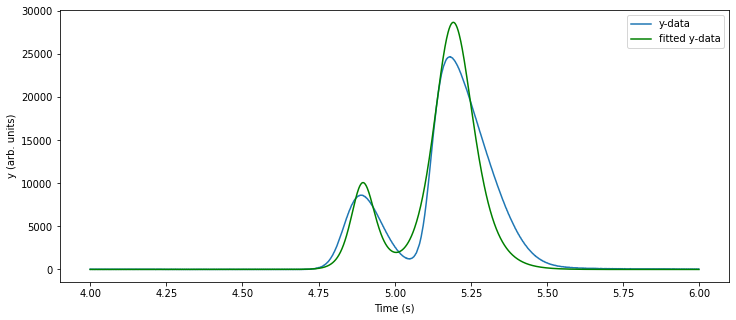

In [85]:
GLM_guess_y = pk_sum(x, 'GLM', *GLM_p0)
two_plot(x,y, GLM_guess_y)

In [0]:
opt_GLM = least_squares(residual, GLM_p0, loss='linear', bounds=(-np.inf, np.inf), args=(y, x, 'GLM'))
GLM_p, GLM_resid = opt_GLM.x, opt_GLM.fun

In [0]:
opt_GLM_pks = component_pks(x, 'GLM', *GLM_p) # list of individual optimized gaussian peaks

In [88]:
opt_GLM_pk_areas = peak_areas(x, opt_GLM_pks)

Area 1  is 19.71% of the whole area
Area 2  is 80.29% of the whole area


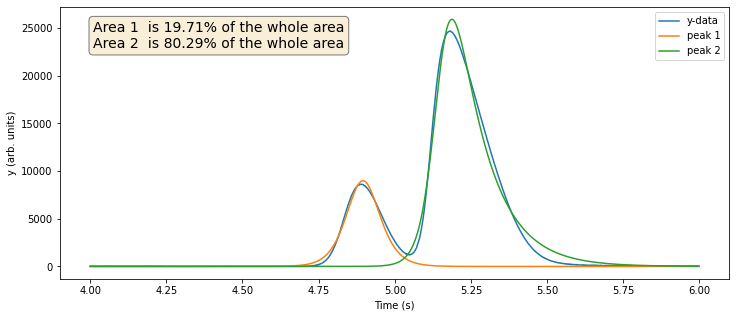

In [89]:
fit_summary(x, y, opt_GLM_pks, opt_GLM_pk_areas)

In [90]:
R2_GLM = R2(GLM_resid, y)
R2_GLM

0.9914031999790254

In [91]:
# LMG_fitted_y = LMG_pk_sum(t, *LMGguess)
wsd_GLM = wsd(y, sum(opt_GLM_pks))
wsd_GLM

944.8796841274242

In [92]:
AOO_GLM = overlap(x, y, sum(opt_GLM_pks))
AOO_GLM

0.9438079229893995

In [93]:
dca_GLM = dca(x, y, sum(opt_GLM_pks))
dca_GLM

0.6789517102572296

# Haarhoff-van der Linde (HVL) model

$$y = \frac{hw}{at_R\sqrt{2\pi}} \frac{exp\left[-\frac{1}{2} \left(\frac{t-t_r}{w}\right)^2\right]}
                                         {\left[exp\left(\frac{at_R}{w^2}\right)-1\right]^{-1} + 
                                         \frac{1}{2}\left[1 + erf\left(\frac{t-t_R}{w\sqrt2}\right)\right]}$$

Good fit, but can be overly sensitive to parameter errors 
Since it combines Gaussian model a triangular function.  For asymmetrical peaks, the asymmetry factor 'a' influences the values of other parameters, making their interpretation difficult and requiring non-intuitive scaling factors to the initial parameters to enable a fit.  
from: Haarhoff, P. H., Van der Linde, H. J., Anal. Chem. 1966, 38, 573–582. and García-Alvarez-Coque et. al. Electrophoresis 2005, 26, 2076–2085



# Kendrick Mods to Haarhoff-van der Linde (HVL) model

$$y = h\frac{exp\left[-\frac{1}{2} \left(\frac{t-\mu}{\sigma}\right)^2\right]}
                                         {\left[exp\left(\frac{a\mu}{10^4a\sigma^2}\right)\right]^{-1} + 
                                         \frac{1}{2}\left[erf\left(\frac{t-\mu}{\sigma\sqrt2}\right)\right]}$$

Removed parameters that did not appreciably impact the overall fit, and modified asymmetry factor multiplication factor



In [0]:
def HVL(x, h, s, mu, a):
    return h * (exp(-1/2 * ((x-mu)/s)**2))/(1/(exp(a*mu/(1e4*s**2))) + 1/2 * (erf((x-mu)/(s*sqrt(2)))))  

In [0]:
a = 0.001 # Asymmetry factor has trouble fitting mix of asymmetric and symmetric peaks. 
          # Use approx 1 for highly symmetric peaks.  Stay between 0.1 h < 10 for triangular peaks.  

HVL_p0 = list(ravel([[p1, p2, p3, a] for (p1, p2, p3) in zip(h, s, mu)])) # initial curve fitting params

In [0]:
y_HVL_p0 = pk_sum(x, 'HVL', *HVL_p0)

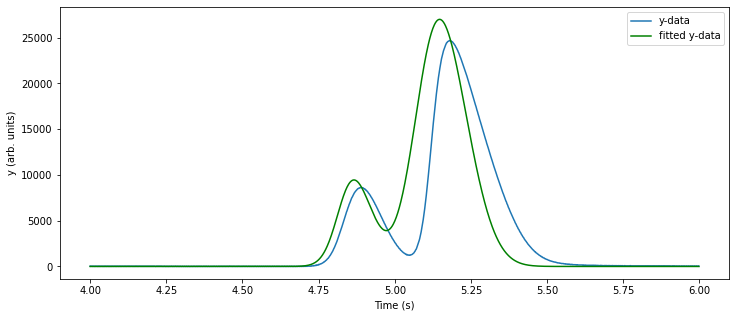

In [97]:
two_plot(x, y, y_HVL_p0)

In [0]:
opt_HVL = least_squares(residual, HVL_p0, loss='linear', bounds=(-np.inf, np.inf), args=(y, x, 'HVL'))
HVL_p, HVL_resid = opt_HVL.x, opt_HVL.fun

In [0]:
opt_HVL_pks = component_pks(x, 'HVL', *HVL_p) # list of individual optimized gaussian peaks

In [100]:
opt_HVL_pk_areas = peak_areas(x, opt_HVL_pks)

Area 1  is 20.68% of the whole area
Area 2  is 79.32% of the whole area


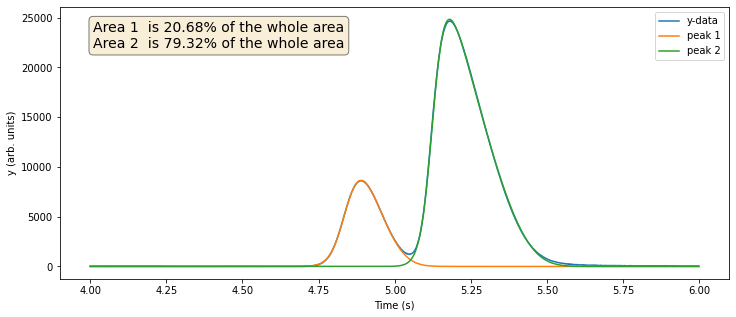

In [101]:
fit_summary(x, y, opt_HVL_pks, opt_HVL_pk_areas)

In [102]:
R2_HVL = R2(HVL_resid, y)
R2_HVL

0.9998096852714173

In [103]:
# LMG_fitted_y = LMG_pk_sum(t, *LMGguess)
wsd_HVL = wsd(y, sum(opt_HVL_pks))
wsd_HVL

115.87613704320047

In [104]:
AOO_HVL = overlap(x, y, sum(opt_HVL_pks))
AOO_HVL

0.9898084770925553

In [105]:
dca_HVL = dca(x, y, sum(opt_HVL_pks))
dca_HVL

0.9510443588338321

# Parabolic Lorentzian-modified Gaussian (PLMG) model

$$y = h*exp\left[-\frac{1}{2} \frac{(t-t_r)^2}{w_0^2 + c^2\frac{(t-t_r + d)^2}{1 + m^2 (t-t_r-r)^2}}\right]$$

Acceptable fit, but can easily converge to different minima, parameters need much different starting points for each peak, and parameters aren't intuitive  
from García-Alvarez-Coque et. al. Electrophoresis 2005, 26, 2076–2085

In [0]:
def PLMG(x, h, mu, w0, d, c, r, m):
    # h: pk_height
    # u: peak center
    # w0, d, c: parabolic parameters
    # r, m:  Lorentzian parameters        
    return h*exp(-1/2 * (x-mu)**2 / (w0**2 + c**2 + (x-mu+d)**2 / (1+m**2*(x-mu-r)**2)))

In [0]:
w0 = [-0.005, -0.005]
d = [-1, 0.4]
c = [-0.05, -0.05] #values > 0.1 create very broad peaks, values < -0.01 create very narrow peaks
r = [-15, -15] # values between -5 to 5 create very broad tailing peaks, values < -5 work well
m = [1, 1] # values vary significantly depending on peak spacing
PLMG_p0 = list(flatten(zip(h, mu, w0, d, c, r, m))) # create 1-D list of all peak fitting parameters

b = 0.02 # Asymmetry factor
# This method of creating a flat p0 list makes it easy to iterate in the empirical parameters

# LMG_p0 = list(ravel([[p1, p2, p3, b] for (p1, p2, p3) in zip(h, mu, s)])) # initial curve fitting params

In [0]:
# PLMG_p0

In [0]:
# PLMG_p.tolist()

In [0]:
y_PLMG_p0 = pk_sum(x, 'PLMG', *PLMG_p0)  # y data of initial parameter estimates

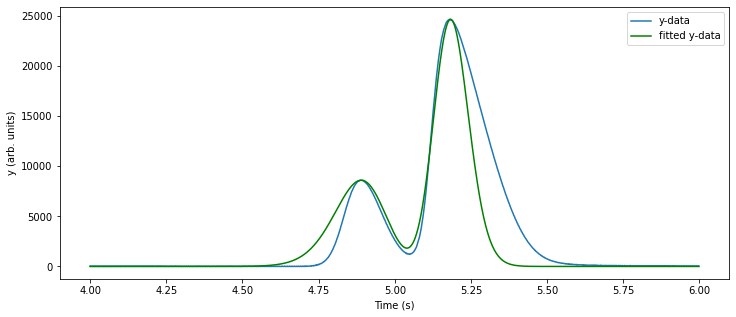

In [111]:
two_plot(x,y, y_PLMG_p0)

In [0]:
opt_PLMG = least_squares(residual, PLMG_p0, loss='linear', bounds=(-np.inf, np.inf), args=(y, x, 'PLMG'))
PLMG_p, PLMG_resid = opt_PLMG.x, opt_PLMG.fun

In [0]:
opt_PLMG_pks = component_pks(x, 'PLMG', *PLMG_p) # list of individual optimized gaussian peaks

In [114]:
opt_PLMG_pk_areas = peak_areas(x, opt_PLMG_pks)

Area 1  is 20.23% of the whole area
Area 2  is 79.77% of the whole area


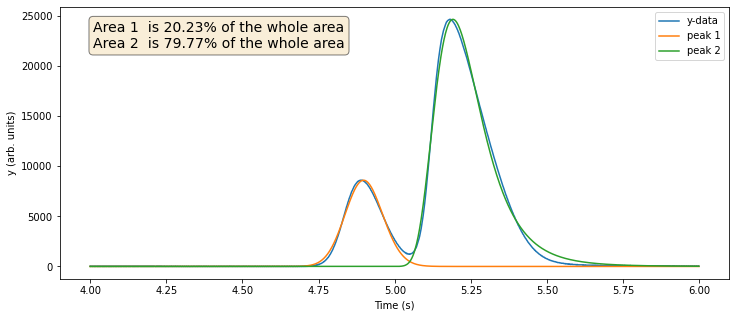

In [115]:
fit_summary(x, y, opt_PLMG_pks, opt_PLMG_pk_areas)

In [116]:
R2_PLMG = R2(PLMG_resid, y)
R2_PLMG

0.9962874578830004

In [117]:
# LMG_fitted_y = LMG_pk_sum(t, *LMGguess)
wsd_PLMG = wsd(y, sum(opt_PLMG_pks))
wsd_PLMG

651.2860013887058

In [118]:
AOO_PLMG = overlap(x, y, sum(opt_PLMG_pks))
AOO_PLMG

0.9641661942774741

In [119]:
dca_PLMG = dca(x, y, sum(opt_PLMG_pks))
dca_PLMG

0.7925047062511943

# Empirically transformed Gaussian (ETG) peak model

$$ y = \frac{h2}{\left[1 + {\lambda_L}e^{k_L(t_L - t)}\right]^{(t_L/t)^\alpha} +
                         \left[1 + {\lambda_T}e^{k_T(t - t_T)}\right]^{(t/t_T)^\beta} - 1}$$
where:
 - t is time
 - h2 is related to peak amplitude
 - ${\lambda_L}$ and ${\lambda_T}$ are pre-exponential parameters
 - ${k_L}$ and ${k_T}$ are parameters related to speed of rise and fall of leading and trailing edges, respectively
 - $\alpha$ and $\beta$ are parameters to further modify shapes of leading and trailing edges, respectively
 - $t_L$ and $t_T$ are x-positions of leading and trailing edges at fwhm
 
 J. Li, “Comparison of the capability of peak functions in describing real chromatographic peaks,” Journal of Chromatography A, vol. 952, no. 1–2, pp. 63–70, Apr. 2002


In [0]:
def ETG(x, h2, L, T, kL, kT, a, b, tL, tT):
    '''
    h: pk ht
    L, T: lambda left, lambda right pre-exponential intially set at 1 
        (seems to usually fit somewhere btwn 1 - 2, 
        L: higher number moves peak to right, decreases height, smaller slope, must be > 0)
        T: higher number moves peak to left, decreases height, smaller slope, must be > 0
    kL, kT: left, right edge rise: intially set at about 4 / fwhm:  i.e for fwhm = 0.1, set at 40
            lower number decreases peak slope (seems to usually be between 0.1/fwhm and 100/fwhm)
    a, b: leading, trailing edge shape, higher number gives higher slope at peak bottoms
            must be > 0.5 and <10  in most cases
    tL and tT are global variables from left and right sides of fwhm
    '''
    return h2/((1+L*exp(kL*(tL-x)))**(tL/x)**a + (1+T*exp(kT*(x-tT)))**(x/tT)**b - 1)

In [0]:
h2 = h*1.2 # need to usually adjust peak heights up a bit
L, T = 1, 1
kL, kT = 4/fwhm, 4/fwhm
a, b = 1, 1
tL, tT =  pk_half_L, pk_half_R  # set global tL and tT variables for ETG peak model based on peak characteristics

# This method of creating a flat p0 list makes it easy to iterate in the empirical parameters

ETG_p0 = list(ravel([[p1, L, T, p2, p3, a, b, p4, p5] for (p1, p2, p3, p4, p5) in zip(h2, kL, kT, tL, tT)])) # initial curve fitting params

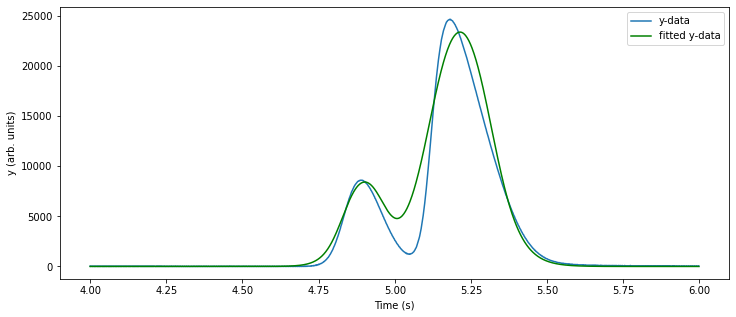

In [122]:
y_ETG_p0 = pk_sum(x, 'ETG', *ETG_p0)
two_plot(x, y, y_ETG_p0)

In [0]:
# Create boundaries for curve fitting (need high (1st list) 
# and low (2nd list) values for every parameter in every peak)

k_low = [0.1/x for x in fwhm]
k_high = [100/x for x in fwhm]

tL_low = [x-0.00001 for x in tL]
tL_high = [x+0.00001 for x in tL]
tT_low = [x-0.00001 for x in tT]
tT_high = [x+0.00001 for x in tT]

bnd_low = []
bnd_high = []
for i in range(len(pk_idx)):
    bnd_low_temp = [0, 0, 0, k_low[i], k_low[i], 0.5, 0.5, tL_low[i], tT_low[i]]
    bnd_high_temp = [1e9, 1e6, 1e6, k_high[i], k_high[i], 10, 10, tL_high[i], tT_high[i]]
    bnd_low += bnd_low_temp
    bnd_high += bnd_high_temp
    
bnds = (bnd_low,bnd_high)
# bnds

In [0]:
opt_ETG = least_squares(residual, ETG_p0, loss='linear', bounds=bnds, args=(y, x, 'ETG'))
ETG_p, ETG_resid = opt_ETG.x, opt_ETG.fun

In [0]:
opt_ETG_pks = component_pks(x, 'ETG', *ETG_p) # list of individual optimized gaussian peaks

In [126]:
opt_ETG_pk_areas = peak_areas(x, opt_ETG_pks)

Area 1  is 20.73% of the whole area
Area 2  is 79.27% of the whole area


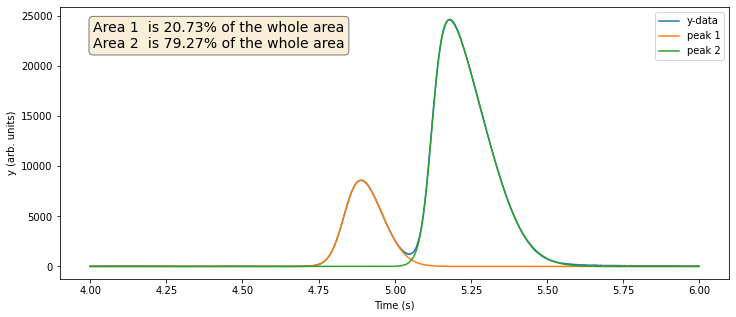

In [127]:
fit_summary(x, y, opt_ETG_pks, opt_ETG_pk_areas)

In [128]:
R2_ETG = R2(ETG_resid, y)
R2_ETG

0.9999338376796193

In [129]:
# LMG_fitted_y = LMG_pk_sum(t, *LMGguess)
wsd_ETG = wsd(y, sum(opt_ETG_pks))
wsd_ETG

65.18865735223876

In [130]:
AOO_ETG = overlap(x, y, sum(opt_ETG_pks))
AOO_ETG

0.9932684365454346

In [131]:
dca_ETG = dca(x, y, sum(opt_ETG_pks))
dca_ETG

0.9568914857956992

# LMG Gaussian model

Linear modified gaussian, from J.Chrom.A. 2017, 1515, 129-137

In [0]:
def LMG(x, h, mu, s, b):
    from numpy import exp
     # h peak height
     # mu elution time
     # s std dev of symm peak that behaves as the asym peak near it's max
     # b peak asymmetry
    tc = x - mu
    return h*exp(-tc**2/2.0/(s-b*tc)**2)

In [0]:
b = 0.02 # Asymmetry factor
# This method of creating a flat p0 list makes it easy to iterate in the empirical parameters

LMG_p0 = list(ravel([[p1, p2, p3, b] for (p1, p2, p3) in zip(h, mu, s)])) # initial curve fitting params

In [0]:
y_LMG_p0 = pk_sum(x, 'LMG', *LMG_p0)

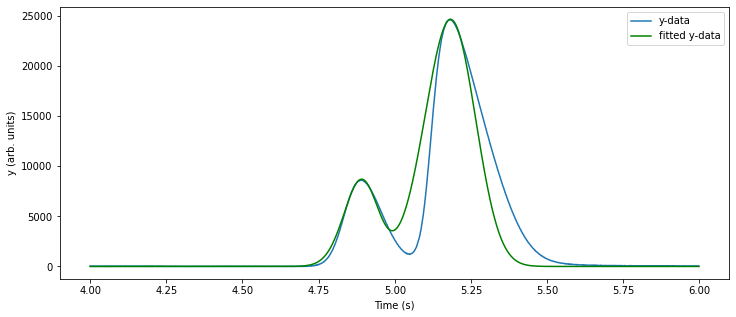

In [135]:
two_plot(x, y, y_LMG_p0)

In [0]:
opt_LMG = least_squares(residual, LMG_p0, loss='linear', bounds=(-np.inf, np.inf), args=(y, x, 'LMG'))
LMG_p, LMG_resid = opt_LMG.x, opt_LMG.fun

In [0]:
opt_LMG_pks = component_pks(x, 'LMG', *LMG_p) # list of individual optimized gaussian peaks

In [138]:
opt_LMG_pk_areas = peak_areas(x, opt_LMG_pks)

Area 1  is 20.28% of the whole area
Area 2  is 79.72% of the whole area


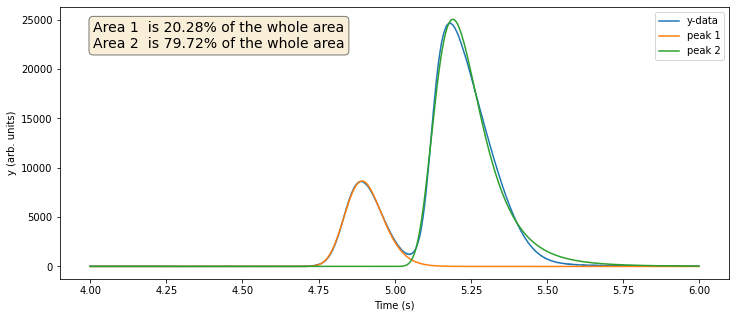

In [139]:
fit_summary(x, y, opt_LMG_pks, opt_LMG_pk_areas)

In [140]:
R2_LMG = R2(LMG_resid, y)
R2_LMG

0.9965078304832778

In [141]:
# LMG_fitted_y = LMG_pk_sum(t, *LMGguess)
wsd_LMG = wsd(y, sum(opt_LMG_pks))
wsd_LMG

653.300260844955

In [142]:
AOO_LMG = overlap(x, y, sum(opt_LMG_pks))
AOO_LMG

0.9674947456714007

In [143]:
dca_LMG = dca(x, y, sum(opt_LMG_pks))
dca_LMG

0.8149675817049755

# Result Summary

Peak Model optimization summary

In [0]:
pk_fitted_ys = [opt_gauss_pks, opt_EMG_pks, opt_GEMG_pks, 
                opt_LMG_pks, opt_GLM_pks, opt_HVL_pks, 
                opt_PLMG_pks, opt_ETG_pks]

In [0]:
sum_pk_fitted_ys = [sum(opt_gauss_pks), sum(opt_EMG_pks), sum(opt_GEMG_pks), 
                    sum(opt_LMG_pks), sum(opt_GLM_pks), sum(opt_HVL_pks),
                   sum(opt_PLMG_pks), sum(opt_ETG_pks)]

In [0]:
pk_fitted_resids = [gaussian_resid, EMG_resid, GEMG_resid, 
                    LMG_resid, GLM_resid, HVL_resid, PLMG_resid, ETG_resid]

In [0]:
pk_R2s = [R2_gaussian, R2_EMG, R2_GEMG, R2_LMG, R2_GLM, R2_HVL, R2_PLMG, R2_ETG]

In [0]:
pk_AOOs = [AOO_gaussian, AOO_EMG, AOO_GEMG, AOO_LMG, AOO_GLM, AOO_HVL, AOO_PLMG, AOO_ETG]

In [0]:
pk_WSDs = [wsd_gaussian, wsd_EMG, wsd_GEMG, wsd_LMG, wsd_GLM, wsd_HVL, wsd_PLMG, wsd_ETG]

In [0]:
pk_DCAs = [dca_gaussian, dca_EMG, dca_GEMG, dca_LMG, dca_GLM, dca_HVL, dca_PLMG, dca_ETG]

In [0]:
pk_areas = [opt_gauss_pk_areas, opt_EMG_pk_areas, opt_GEMG_pk_areas, opt_LMG_pk_areas, 
           opt_GLM_pk_areas, opt_HVL_pk_areas,
           opt_PLMG_pk_areas, opt_ETG_pk_areas]

In [0]:
pk_labels = ['Gaussian Model', 'Exponentially Modified Gaussian Model', 'Generalized Exponentially Modified Gaussian Model',
             'Linear Modified Gaussian Model', 'Generalized Logistic Model', 'Haarhoff-van der Linde Model',
            'Parabolic Lorentzian-Modified Gaussian Model', 'Empirically Transformed Gaussian Model']

In [0]:
def res_plots(x, y, fitted_y_sum, fitted_y, resids, R2, AOO, wsd, dca, pk_areas, labels):
    
    numrows = round(len(fitted_y)/2)
    numcols = 2
    figsize_width = 15*numcols
    figsize_height = 8*numrows
    fig, axs = plt.subplots(numrows, numcols, figsize=(figsize_width, figsize_height))

    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 20

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    def two_scales(ax1, time, data1, data2, data3, data4, label, c1, c2, c3):

        ax2 = ax1.twinx()

        ax1.plot(time, data1, color=c1)
        ax1.plot(time, data2, color=c2, linewidth=2)
        ax1.plot(time, data3[0], '--', linewidth=2, color = 'g')
        ax1.plot(time, data3[1], '--', linewidth=2,color = 'y')
        ax1.legend(['Chromatogram', 'Fitted Peak Sum', 'Fitted Peak 1', 'Fitted Peak 2'])
        ax1.set_xlabel('Retention time (m)')
        ax1.set_ylabel('chromatogram y', color='k')

        ax1.set_ylim(-30000,30000)
        ax1.set_title(label)

        ax2.plot(time, data4, color=c3)
        ax2.set_ylabel('residual y', color='k',rotation=270)
        ax2.set_ylim(-8000, 15000)
        ax2.legend(['residual'],loc='lower right')
        textstr = '\n'.join((
            'R\u00b2 = {:.4f}'.format(R2[i]),
            'Area of overlap = {:.2f}'.format(AOO[i]),
            'WSD = {:.0f}'.format(wsd[i]),
            'DCA = {:.2f}'.format(dca[i]), '\n',
            'Peak {}  is {:1.1%} area'.format('1', pk_areas[i][0]),
            'Peak {}  is {:1.1%} area'.format('2', pk_areas[i][1])))

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=20,
                verticalalignment='top', bbox=props)   
        
        # Change color of each axis
        def color_y_axis(ax, color):
            """Color your axes."""
            for t in ax.get_yticklabels():
                t.set_color(color)
            return None
        color_y_axis(ax1, 'k')
        color_y_axis(ax2, 'k')  

    count = 0
    for i in range(int(len(fitted_y))):

        if i % 2 == 0:
            # Create axes
            two_scales(axs[count,0], x, y, fitted_y_sum[i], fitted_y[i], resids[i], labels[i], 'r', 'b', '0.75')
                       
        else:
            # Create axes
            two_scales(axs[count,1], x, y, fitted_y_sum[i], fitted_y[i], resids[i], labels[i], 'r', 'b', '0.75') 

            count += 1

    plt.tight_layout()
#     plt.savefig('peak_distribution_models.png', resolution='600dpi')

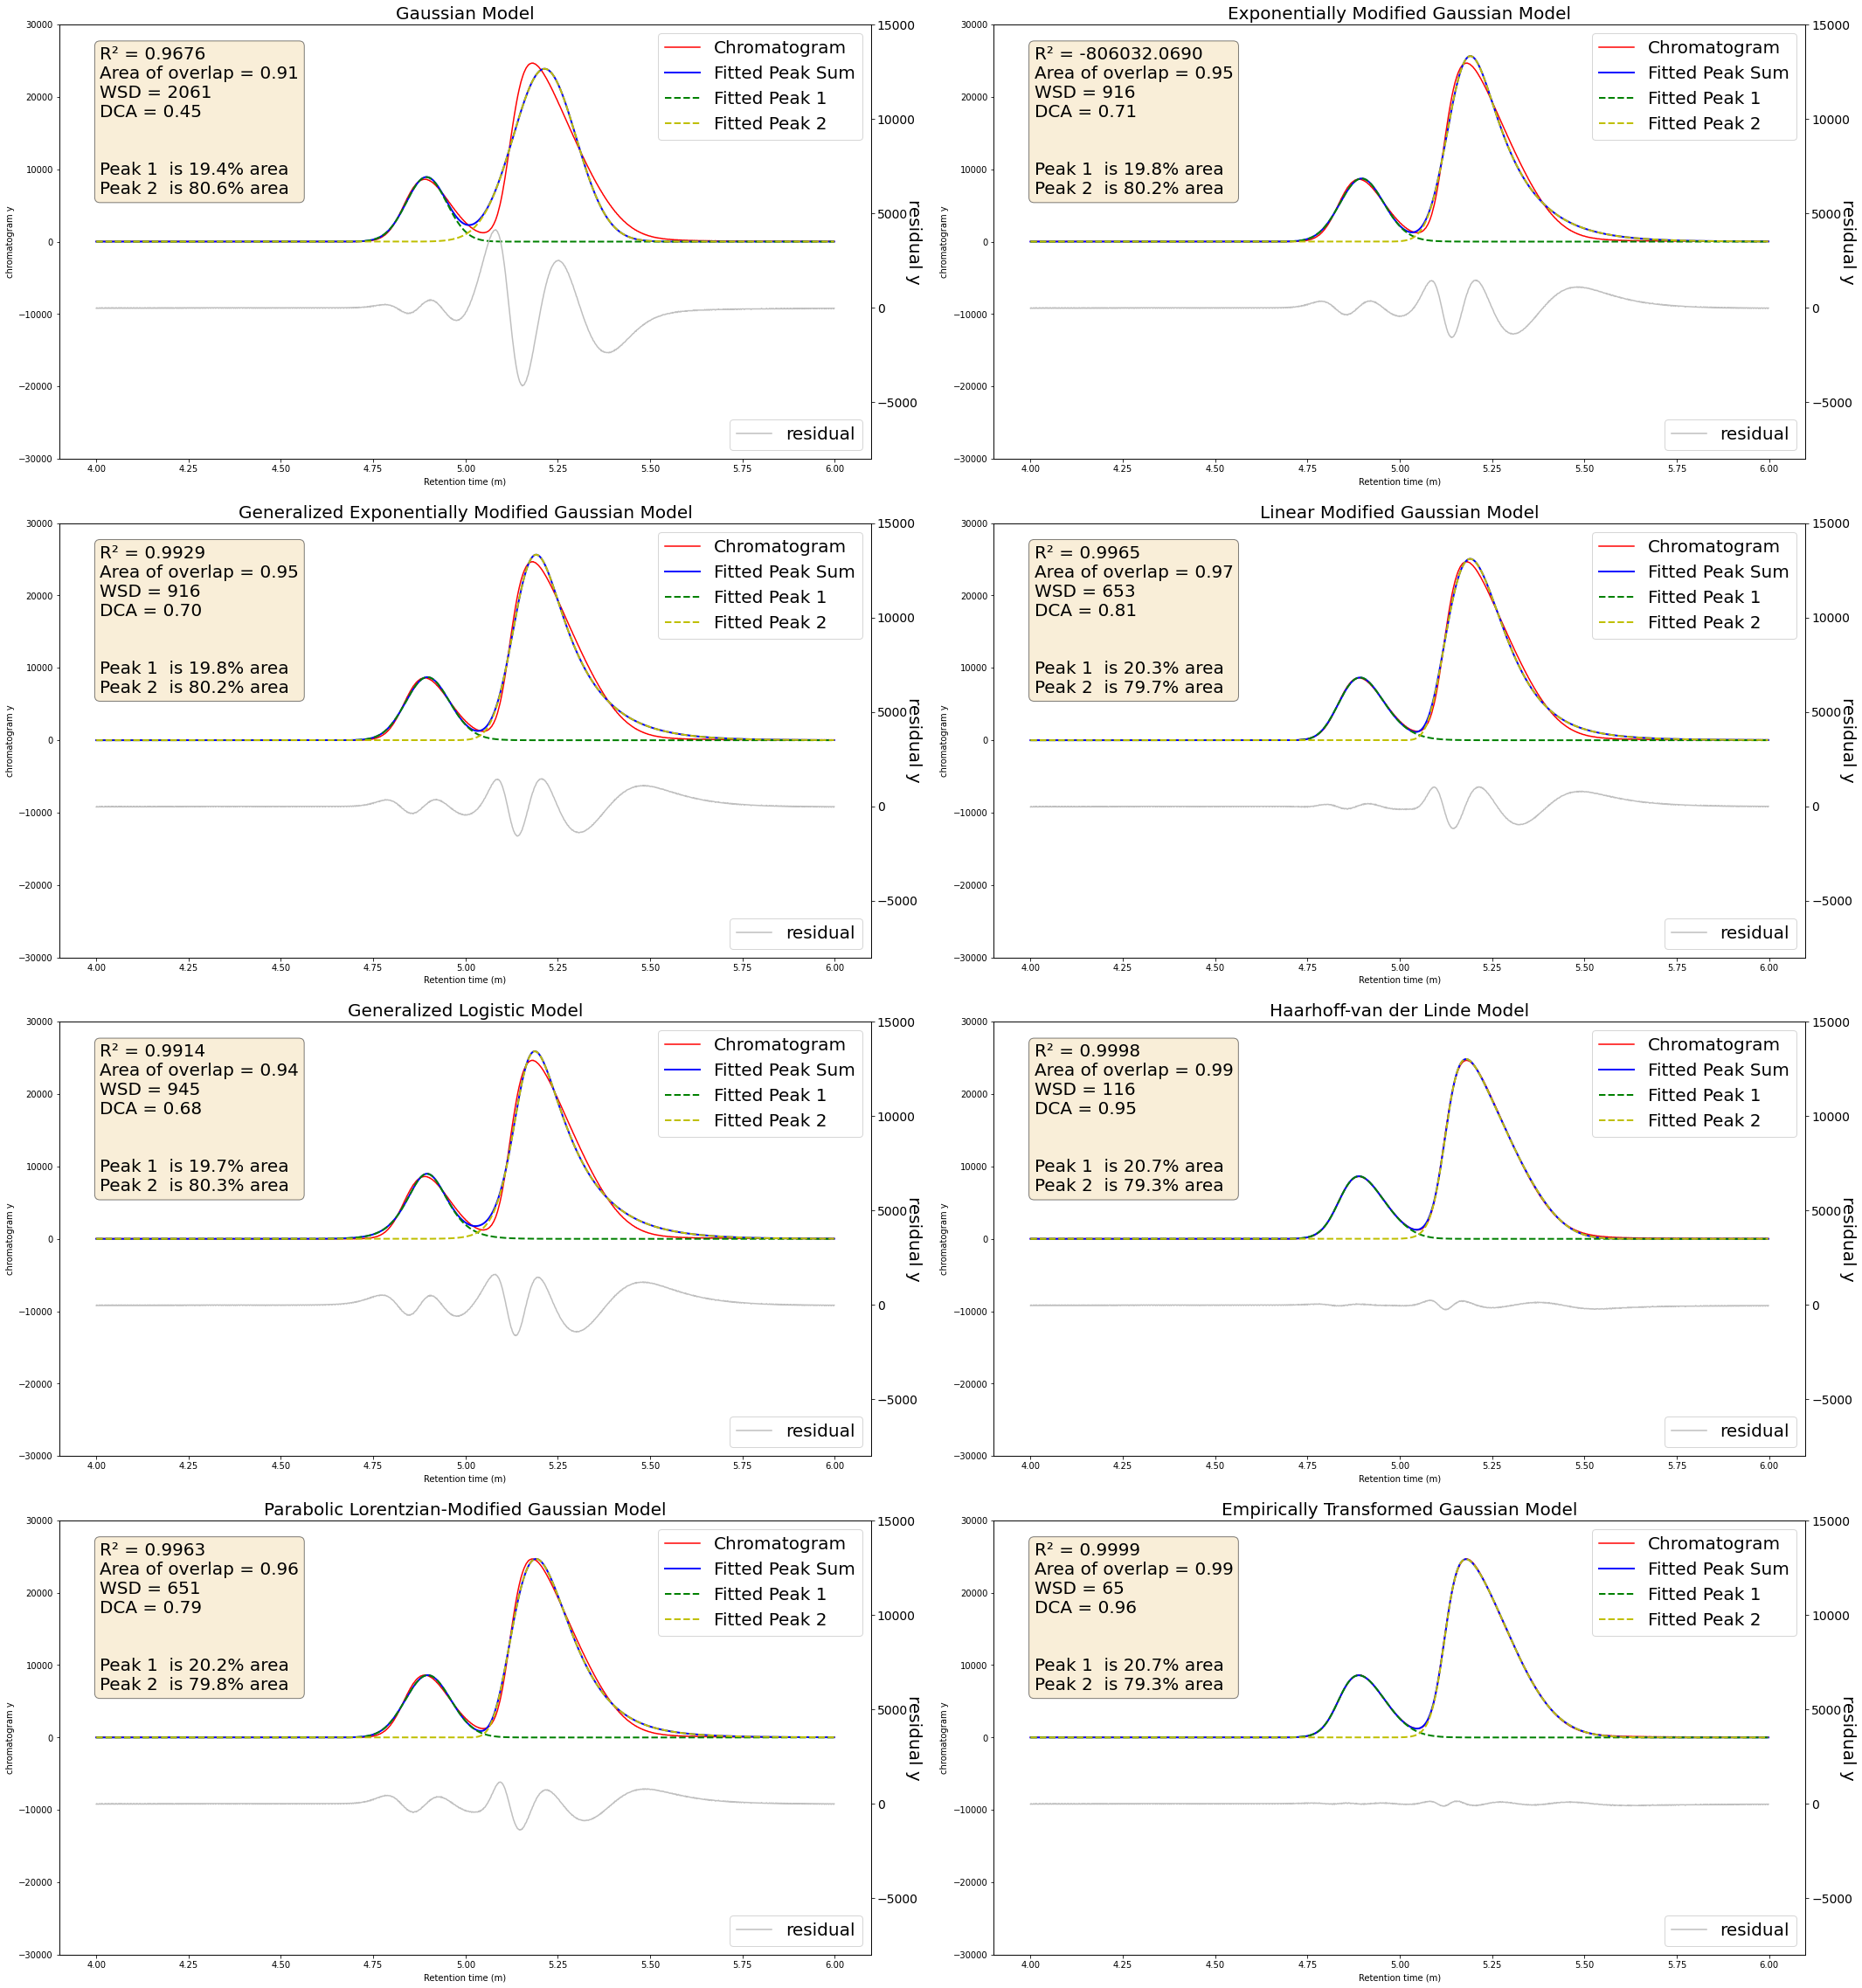

In [154]:
res_plots(x, y, sum_pk_fitted_ys, pk_fitted_ys, pk_fitted_resids, pk_R2s, pk_AOOs, pk_WSDs, pk_DCAs, pk_areas,pk_labels)